# Solutions: Unit 6
-------------------

Complete the problems below in your copy of the Jupyter Notebook.

## Problem 6.1.

When conducting laboratory measurements, it is common practice to build a calibration curve by measuring the output of the lab instrument with standard samples. In the case of gas chromatography, this is required to determine the *response factor* for a specific chemical in the sensor. The file `gc_calibration.csv` contains calibration data for the measurement of hydrocarbons in polymer samples. The `Concentration` column represents the actual concentration of the hydrocarbon in ppm (mg hydrocarbon / kg polymer). The `FID_Signal` represents the corresponding area measured from the flame ionization detector (FID) signal.

Perform a regression analysis on this model to predict the concentration from the FID signal, so that the concentration in future samples can be estimated.

1. Test first, second and third order polynomial fits
2. Measure the $R^2$ performance of each model
3. Plot the raw data
4. Overlay plots for each polynomial fit on the interval [0, 7000]

Which model would you pick, and why?

In [ ]:
# problem 6.1. solution

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

plt.style.use('ggplot')

# review the data to look at its structure
cal_df = pd.read_csv('../../data/gc_calibration.csv')
cal_df.head()

In [ ]:
# save the data columns as individual numpy.ndarrays, reshaping x as a column vector
cal_x = cal_df['FID_Signal'].to_numpy().reshape(-1, 1)
cal_y = cal_df['Concentration'].to_numpy()

# generate the 3 polynomial feature matrices (1=first order, ...)
cal_X_1 = PolynomialFeatures(1).fit_transform(cal_x)
cal_X_2 = PolynomialFeatures(2).fit_transform(cal_x)
cal_X_3 = PolynomialFeatures(3).fit_transform(cal_x)

# create and fit 3 regression models to the data
# the intercept is included in the PolynomialFeatures
cal_reg_1 = LinearRegression(fit_intercept=False)
cal_reg_1.fit(cal_X_1, cal_y)

cal_reg_2 = LinearRegression(fit_intercept=False)
cal_reg_2.fit(cal_X_2, cal_y)

cal_reg_3 = LinearRegression(fit_intercept=False)
cal_reg_3.fit(cal_X_3, cal_y)

# create an array to plot the predicted values [0, 7000]
predict_fid = np.linspace(0, 7000, 50).reshape(-1, 1)

# also need to transform this array of prediction values to a polynomial
predict_fid_1 = PolynomialFeatures(1).fit_transform(predict_fid)
predict_fid_2 = PolynomialFeatures(2).fit_transform(predict_fid)
predict_fid_3 = PolynomialFeatures(3).fit_transform(predict_fid)

# plot the raw data
fig, ax = plt.subplots()
ax.scatter(cal_x, cal_y)

# don't forget to label the axes
ax.set_xlabel('FID Peak Area')
ax.set_ylabel('Concentration (mg/kg)')

# plot each model prediction as a line
ax.plot(predict_fid, cal_reg_1.predict(predict_fid_1), 
        label=f'1st Order ($R^2$={cal_reg_1.score(cal_X_1, cal_y):0.3f})')

ax.plot(predict_fid, cal_reg_2.predict(predict_fid_2), 
        label=f'2nd Order ($R^2$={cal_reg_2.score(cal_X_2, cal_y):0.3f})')

ax.plot(predict_fid, cal_reg_3.predict(predict_fid_3), 
        label=f'3rd Order ($R^2$={cal_reg_3.score(cal_X_3, cal_y):0.3f})')

ax.legend()

These three models show similar $R^2$ performance over this range of peak areas. All things being equal, I would select the simplest model that performs well, which would be the first order polynomial. It is always risky to use a model outside of the range of the training data. If values higher than 10 mg/kg are relevant to the experiment, I would recommend adding additional calibration points to cover this part of the range.

## Problem 6.2.

Molten polymers typically behave as *pseudoplastic* or *shear-thinning*, non-Newtonian, fluids. This means that their viscosity is not constant, but depends on the shear rate that they are subjected to. For certain ranges of shear rates, the viscosity of a polymer melt may be reasonably described by the Power Law model, which states that: 

$$\eta=K\dot{\gamma}^{n-1}$$

For a shear-thinning fluid, $n<1$. 

The file `viscosity.csv` contains columns for shear-rate, $\dot{\gamma}$, in $rad/s$ and viscosity, $\eta$, in $Pa\cdot s$. Prepare this data and use linear regression to find the constants $K$ and $n$ which best fit the data.

### problem 6.2. solution setup

First, we must transform the data so that a linear regression can be used. By taking the logarithm of both sides of the equation, we can linearize the equation:

$$\log \eta = \log \left[ K \dot{\gamma}^{n-1} \right]$$
$$\log \eta = \log K + \left( n-1 \right) \log \dot{\gamma}$$

By performing a regression on $\log \eta = f(\log \dot{\gamma})$ we can calculate a slope, $n-1$, and intercept, $\log K$.

In [ ]:
# problem 6.2. solution

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# load the data and look at the structure
visc_df = pd.read_csv('../../data/viscosity.csv')
visc_df.head()

In [ ]:
# take the log of each column
visc_df['log-eta'] = np.log(visc_df['eta'])
visc_df['log-gamma-dot'] = np.log(visc_df['gamma-dot'])

# convert the data to numpy.ndarrays
# optional as a separate step, but cleans up the code
visc_x = visc_df['log-gamma-dot'].to_numpy().reshape(-1, 1)
visc_y = visc_df['log-eta'].to_numpy()

# use linear regression, fit intercept to simplify code
visc_reg = LinearRegression(fit_intercept=True)
visc_reg.fit(visc_x, visc_y)

# calculate the constants from the slope and intercept
K = np.exp(visc_reg.intercept_)
n = visc_reg.coef_[0] + 1

# plot the original data on a log-log scale
fig, ax = plt.subplots()
ax.scatter(visc_df['gamma-dot'], visc_df['eta'])

ax.loglog()
ax.set_xlabel(r'$\dot{\gamma} (rad/s)$')
ax.set_ylabel(r'$\eta$ ($Pa\cdot s$)')

# plot the predicted values, remembering to convert by taking the exponential
ax.plot(visc_df['gamma-dot'], np.exp(visc_reg.predict(visc_x)))

# add text for the constants
ax.text(100, 1000, f'K={K:0.3f}, n={n:0.3f}')

## Problem 6.3.

The file `film_classification_extended.csv` contains a greater number of features and observations for the BOPET v. BOPP classification problem that was discussed previously. Load this data set, generate a scaled feature matrix and array of class labels. Then, experiment with different neural network architectures to test the effect of nodes per layer and number of hidden layers. Describe your results.

In [1]:
# problem 6.3. solution

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

# load the data and look at the structure
film_df = pd.read_csv('../../data/film_classification_extended.csv')
film_df.head()


,filmtype,dart,elongation-MD,elongation-TD,modulus-MD,modulus-TD,strength-MD,strength-TD
0,BOPET,0.447421,165.0,144.0,4321.0,4355.0,179.0,220.0
1,BOPET,0.501653,141.0,125.0,4211.0,4597.0,168.0,205.0
2,BOPET,0.528770,141.0,135.0,4200.0,4388.0,162.0,218.0
3,BOPET,0.488095,155.0,151.0,4199.0,4439.0,174.0,211.0
4,BOPET,0.474537,166.0,112.0,4221.0,4380.0,177.0,200.0


In [2]:
# extract the X matrix from the data
# we slice the array of column names to exclude the filmtype column
film_X = film_df[film_df.columns[1:]].to_numpy()

# scale the X matrix
film_X_scaled = StandardScaler().fit_transform(film_X)

# create an array of labels, 1 for BOPET and -1 for BOPP, using list comprehension
film_labels = [1 if x=='BOPET' else -1 for x in film_df['filmtype']]

# optional: create a loop to test many values
# we will test multiples of 10 nodes per hidden layer
nodes_per_layer = np.arange(10, 160, 10)

# empty array to hold scores of 1, 2, 3, 4 layers x 15 nodes/layer values
scores = np.zeros((4, len(nodes_per_layer)))

# loop through the nodes_per_layer array to calculate score
for i, n in enumerate(nodes_per_layer):

    # create a 1-layer neural net
    clf_nn_1 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                             hidden_layer_sizes=(n),
                             random_state=1)

    # test performance of the 1-layer model using cross-validation
    scores[0, i] = cross_validate(clf_nn_1, film_X_scaled, film_labels)['test_score'].mean()

    # create a 2-layer neural net
    clf_nn_2 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                             hidden_layer_sizes=(n, n),
                             random_state=1)

    # test performance of the 2-layer model using cross-validation
    scores[1, i] = cross_validate(clf_nn_2, film_X_scaled, film_labels)['test_score'].mean()

    # create a 3-layer neural net
    clf_nn_3 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                             hidden_layer_sizes=(n, n, n),
                             random_state=1)

    # test performance of the 3-layer model using cross-validation
    scores[2, i] = cross_validate(clf_nn_3, film_X_scaled, film_labels)['test_score'].mean()

    # create a 4-layer neural net
    clf_nn_4 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                             hidden_layer_sizes=(n, n, n, n),
                             random_state=1)

    # test performance of the 4-layer model using cross-validation
    scores[3, i] = cross_validate(clf_nn_4, film_X_scaled, film_labels)['test_score'].mean()


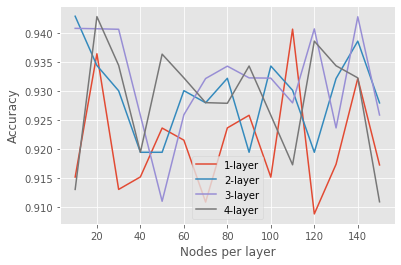

In [3]:
# display the results of the test
plt.style.use('ggplot')

fig, ax = plt.subplots()

ax.plot(nodes_per_layer, scores[0, :], label='1-layer')
ax.plot(nodes_per_layer, scores[1, :], label='2-layer')
ax.plot(nodes_per_layer, scores[2, :], label='3-layer')
ax.plot(nodes_per_layer, scores[3, :], label='4-layer')

ax.set_xlabel('Nodes per layer')
ax.set_ylabel('Accuracy')

ax.legend()

From this test, we can see that increasing model complexity, especially with a small dataset, does not improve accuracy of the classifier. We are seeing accuracy of about 93-94% with 1-4 hidden layers. The simpler models, with 20 nodes perform the best in this test. Further work could be done to pre-process (or possibly add new) features to improve the model.

--------------
## Next Steps:

1. Advance to [Unit 7](../07-advanced-plotting/unit07-lesson.ipynb) when you're ready for the next step